# AdaBoost

## 1 decision stump

In [1]:
import numpy as np

In [2]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    """
    dataMatrix: the data matrix
    dimen : every data dimension(just the feature)
    threshVal: Threshold of the current decision
    threshIneq: the direction of the threshold
    return: array for decide the leabel threshold
    """
    errArr = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'lt': 
        errArr[dataMatrix[:, dimen] <= threshVal] = -1 # errArr = [-1, -1, -1, ..., 1, 1, 1] 
    else:
        errArr[dataMatrix[:, dimen] > threshVal] = -1 # errArr = [1, 1, 1, 1...., -1, -1, -1]
    return errArr

In [3]:
def buildStump(dataArr, classLabels, D):
    """
    dataArr: the data
    classLabels: the label for -1 and +1
    D: the weight of the current error
    return best Stump, min error and best class Class 
    """
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = np.shape(dataMatrix)
    numSteps = 10.0 # the step of increase
    bestStump = {} # record the current best decision stump
    bestClassThreshold = np.mat(np.zeros((m, 1)))
    minError = np.inf
    # three cycle 
    # 1. every feature cycle
    # 2. eevery data in the current cycle to decide the threshold
    # 3. to decide the direction of the threshold
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        step = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1): # for the step : (-1) -> (numSteps + 1) the step can try to set lot
            for k in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * step)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, k)
                errArr = np.mat(np.ones((m, 1))) # initial the array for 1. if label right change 0
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, k, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassThreshold = predictedVals.copy()  # [-1 -1 -1 ... 1 1 1 1 ] or reverse
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = k
    return bestStump, minError, bestClassThreshold
                    
        
        

In [4]:
def loadSimData():
    datMat = np.matrix([
        [1. , 2.1],
        [2. , 1.1],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]
    ])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [5]:
datMat, classLabels = loadSimData()

In [6]:
D = np.mat(np.ones((5, 1)) / 5)

In [7]:
buildStump(datMat, classLabels, D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 2 complete adaboost

In [8]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    """
    numIt: iterator times
    """
    weekClassArr = [] # classifier for the every dimension
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m) #initial the weight matrix
    aggClassEst = np.mat(np.zeros((m, 1))) # record every data according each classifier label value sum
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print("D:", D.T)
        alpha = float(0.5 * np.log((1 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weekClassArr.append(bestStump)
        print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst # the result of the classifier
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weekClassArr, aggClassEst
        

In [13]:
classifierArray, aggClassEst = adaBoostTrainDS(datMat, classLabels)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [14]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 3. classifier function

In [15]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len((classifierArr))):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

In [16]:
adaClassify([0, 0], classifierArray)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

## 4.use adapt load function

In [17]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [18]:
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [23]:
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00335068 0.00843582 0.00179355 0.00843582 0.00451553 0.00179355
  0.00179355 0.00843582 0.00335068 0.00451553 0.00179355 0.00179355
  0.00179355 0.00843582 0.00179355 0.00335068 0.00179355 0.00179355
  0.00179355 0.00335068 0.00451553 0.00179355 0.00179355 0.00179355
  0.00179355 0.00179355 0.00179355 0.00179355 0.00843582 0.00179355
  0.00179355 0.00843582 0.00179355 0.00179355 0.00451553 0.00179355
  0.00843582 0.00843582 0.00179355 0.00843582 0.00179355 0.00179355
  0.00179355 0.00335068 0.00179355 0.00179355 0.00843582 0.00179355
  0.00451553 0.00179355 0.00179355 0.00843582 0.00179355 0.00179355
  0.00451553 0.00843582 0.00179355 0.00335068 0.00179355 0.00179355
  0.00179355 0.00179355 0.00451553 0.00451553 0.00179355 0.00179355
  0.00335068 0.00179355 0.00335068 0.00179355 0.00843582 0.00179355
  0.00843582 0.00179355 0.00843582 0.00843582 0.00179355 0.00179355
  0.00335068 0.00335068 0.00335068 0.00179355 0.00179355 0.00179355
  0.00179355 0.00179355 0.00335068 0.00843582

  -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.]]
aggClassEst:  [[-0.66895971  0.72030514  0.82798452  0.25436505 -0.37059985  0.82798452
   0.82798452  0.25436505 -0.66895971 -0.66895971  0.25436505  0.25436505
   0.82798452  0.25436505  0.72030514 -0.66895971 -1.29392461  0.82798452
   0.25436505 -0.37059985 -0.66895971  0.82798452  0.82798452  0.72030514
   0.72030514  0.25436505  0.25436505  0.82798452  0.82798452  1.29392461
  -1.29392461  0.25436505  0.25436505  0.25436505 -0.66895971 -1.29392461
   0.25436505 -0.82798452  0.82798452  0.25436505 -1.29392461  0.25436505
   0.25436505 -0.20301961 -0.82798452 -1.29392461 -1.29392461  0.82798452
  -0.37059985 -1.29392461  0.82798452  0.25436505  0.82798452  0.82798452
  -0.37059985  0.25436505  0.82798452 -0.66895971 -0.72030514 -1.29392461
   0.82798452  0.25436505 -0.37059985  0.09534024  0.25436505  0.72030514
   0.09534024  0.82798452  0.20301961  0.82798452  0.25436505  0.82798452
   0.25436505 -0.72030514  0.82798452  0.25436505 

D: [[0.00264952 0.0106296  0.00152086 0.00667055 0.00240286 0.00152086
  0.00152086 0.00667055 0.00264952 0.00679523 0.00269904 0.00269904
  0.00152086 0.00667055 0.00169377 0.00264952 0.00141823 0.00225997
  0.00269904 0.00504229 0.00679523 0.00152086 0.00152086 0.00169377
  0.00169377 0.00401073 0.00269904 0.00152086 0.0079665  0.00095441
  0.00141823 0.00667055 0.00269904 0.00269904 0.00679523 0.00141823
  0.00448898 0.0079665  0.00152086 0.00448898 0.00141823 0.00401073
  0.00269904 0.00422204 0.00225997 0.00141823 0.01269471 0.00152086
  0.00357061 0.00141823 0.00152086 0.00667055 0.00152086 0.00225997
  0.00357061 0.00667055 0.00225997 0.00264952 0.00251691 0.00141823
  0.00152086 0.00269904 0.00240286 0.00568982 0.00269904 0.00169377
  0.00316426 0.00152086 0.00422204 0.00152086 0.00448898 0.00152086
  0.00448898 0.00251691 0.0079665  0.00667055 0.00095441 0.00095441
  0.00470204 0.00504229 0.00264952 0.00152086 0.00269904 0.00169377
  0.00269904 0.00152086 0.00264952 0.0079665 

D: [[0.00194028 0.01134815 0.00151025 0.00488494 0.00256529 0.00111375
  0.00151025 0.00662403 0.00263104 0.00497624 0.00288149 0.00268022
  0.00111375 0.0096568  0.00180826 0.00263104 0.00140834 0.00224421
  0.00268022 0.0072996  0.00497624 0.00111375 0.00151025 0.00168196
  0.00180826 0.00398276 0.00288149 0.00220171 0.00850503 0.00094775
  0.00140834 0.00488494 0.00197654 0.00268022 0.00725458 0.00103859
  0.00479243 0.00791094 0.00151025 0.00479243 0.00103859 0.00398276
  0.00390733 0.00309186 0.00224421 0.00103859 0.01355286 0.00151025
  0.00354571 0.00103859 0.00151025 0.00712147 0.00151025 0.00224421
  0.00354571 0.00662403 0.00224421 0.00383564 0.00249936 0.00103859
  0.00151025 0.00197654 0.00347857 0.00416673 0.00390733 0.00245203
  0.0031422  0.00111375 0.00309186 0.00151025 0.00445768 0.00111375
  0.00479243 0.00364367 0.00850503 0.00488494 0.00138167 0.00094775
  0.00466925 0.00369254 0.00194028 0.00111375 0.00390733 0.00124037
  0.00268022 0.00111375 0.00263104 0.00850503

D: [[0.00264962 0.00866853 0.00157324 0.00489163 0.00195955 0.0011602
  0.00115364 0.00904571 0.00263464 0.00380121 0.00300167 0.002792
  0.00085076 0.00967002 0.00138128 0.00263464 0.00141027 0.00224729
  0.002792   0.00760406 0.00518379 0.00085076 0.00157324 0.00168426
  0.00188368 0.00398821 0.00300167 0.00168183 0.00885975 0.00072396
  0.00141027 0.00489163 0.00150983 0.00204734 0.00755715 0.00104002
  0.0036608  0.00792177 0.00115364 0.00499231 0.00104002 0.00398821
  0.0040703  0.00309609 0.00224729 0.00104002 0.01411812 0.00115364
  0.00355057 0.00104002 0.00157324 0.00713123 0.00157324 0.00224729
  0.00484199 0.0066331  0.00224729 0.0038409  0.00250278 0.00104002
  0.00157324 0.00150983 0.00348333 0.00417244 0.0040703  0.0025543
  0.00327325 0.00085076 0.00322081 0.00115364 0.00608735 0.00085076
  0.00499231 0.00364866 0.00885975 0.00489163 0.00105542 0.00072396
  0.00467565 0.00384655 0.00194294 0.00111527 0.0040703  0.00124207
  0.002792   0.0011602  0.00263464 0.00885975 0.0

In [24]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')

In [25]:
prediction10 = adaClassify(testArr, classifierArray)
prediction10

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 

In [26]:
errArr = np.mat(np.ones((67, 1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()

16.0

## 4 ROC(receiver operating characteristic) and AUC(area under the curve)

In [29]:
def plotRoc(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = np.sum(np.array(classLabels) == 1.0) # calculate the positive sample num
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas) # the negetive smaple num
    sortedIndicies = predStrengths.argsort() # sort index
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve for adaboost horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the area under the curve is: ", ySum * xStep)

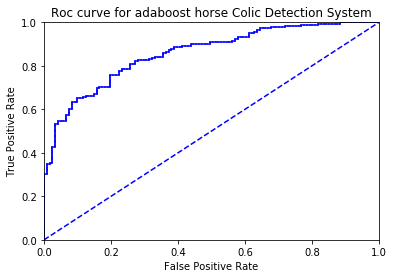

the area under the curve is:  0.8582969635063604


In [30]:
plotRoc(aggClassEst.T, labelArr)